Homework Assignment 1, Neva Nann, HS 2023
# Reading handwritten numbers from A4 sheet of paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import skimage
from skimage.io import imread
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks, resize, estimate_transform, warp
from skimage.measure import label, regionprops

import keras
from keras.datasets import mnist
import ipywidgets as widgets

#### Problem description:
Consider a picture representing a white sheet of A4 paper with some handwritten numbers in a dark color (they have different sizes, but they are all oriented in the same direction, which is aligned with one of the edges of the paper).  Consider the attached pictures as examples. Some are easy, others are harder. Note that the paper might be pictured at an angle or from a slanted perspective.  In all pictures the four edges of the paper are clearly visible, but might be incomplete.

Write a notebook that, given a directory, will process all images in that directory and extract all digits it can find from each picture. For each file, it should then print:

- the name of the file, followed by
- each of the digits that has been identified on that sheet of paper, from top to bottom.

#### Outline of approach:
- Load the image and resize it to a manageable size. You may want to convert it to grayscale.
- Look for edges using the Canny edge detector.
- Look for four long straight lines using the Hough line detector.
- The intersections between pairs of these lines should correspond to the corners of the paper sheet. (note: 4 lines define 6 different intersections!)
- Once you have the four corners of the sheet, you can obtain a straightened version of your sheet of paper, by a geometric transformation.
- Binarize and find connected components (this might be tricky when illumination is uneven. How to fix that?).
- Cut a square bounding box around each connected component.
- Resize that to a 28 x 28 and classify it using a convnet trained on the MNIST dataset.

## 1. Load image, resize, show edges

(604, 806)


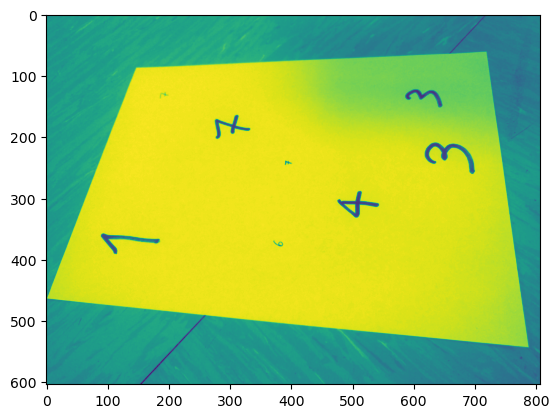

In [56]:
# Load the image and resize it to a manageable size. convert it to grayscale.
folder = 'images_train/'

def get_image(folder, image):
    image = imread(folder + image_name)
    new_shape=(image.shape[0]//5, image.shape[1]//5, image.shape[2])
    image = resize(image, new_shape)
    image_gray = skimage.color.rgb2gray(image)
    return image_gray

image_files = os.listdir(folder)  # list of all images in the folder (training)

image_name="IMG_20190312_183838.jpg"   # landscape example
#image_name="IMG_20190312_183841.jpg"  # portrait example
image_gray = get_image(folder, image_name)

print(image_gray.shape)
plt.imshow(image_gray)

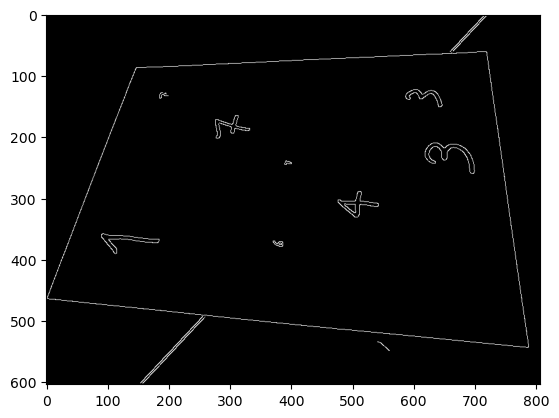

In [3]:
# Look for edges using the Canny edge detector.
edges = canny(image_gray, mode="nearest")
plt.imshow(edges, cmap='gray')

##### plotting the hough line

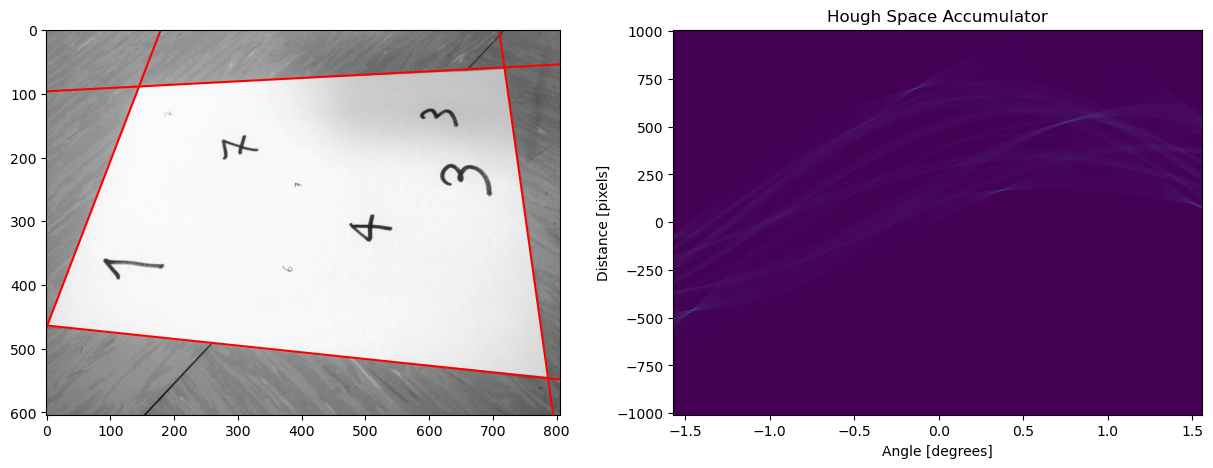

In [4]:
# DEVELOPMENT PROCESS LEFT IN HERE FOR DOCUMENTATION PURPOSES


# plot the line on the image (same, again, expanded - repeated to have the entire code in one place)

# calculate hough space
edges = canny(image_gray, sigma=2.0, mode="nearest")
hspace, angles, distances = hough_line(edges)
peaks, peak_angles, peak_distances = hough_line_peaks(hspace, angles, distances)#, min_distance=10,num_peaks=5)

# plot the image and the Hough space
fig, (ax_image, ax_hspace) = plt.subplots(1, 2, figsize=(15, 5))
ax_image.imshow(image_gray, cmap="gray")
H_space_image = ax_hspace.imshow(hspace, 
                                extent=(angles[0], angles[-1], distances[0], distances[-1]), 
                                origin="lower", 
                                aspect="auto")

ax_hspace.set(xlabel="Angle [degrees]", ylabel="Distance [pixels]", title="Hough Space Accumulator")

# # --- 1. TRY: UNIT VECTOR - FAILED, INCORRECT ---
# for i, peak in enumerate(peaks):
#     angle_deg = peak_angles[i] * 180 / np.pi   # or np.deg2rad(peak_angles[i])
#     distance = peak_distances[i]
    
#     # Calculate the endpoints of the line in Cartesian coordinates
#     p1 = np.array([distance * np.cos(angle_deg), distance * np.sin(angle_deg)])
#     unit_vector = np.array([np.cos(angle_deg + np.pi/2), np.sin(angle_deg + np.pi/2)])
#     p0 = p1 - 1000 * unit_vector
#     p2 = p1 + 1000 * unit_vector
    
#     # Plot the line on the ax_image plot
#     ax_image.plot([p0[0], p2[0]], [p0[1], p2[1]], color='red', linewidth=2, scalex=False, scaley=False)

# # --- 2. TRY: LIN.EQUATION - FAILED, INCORRECT --- 
# for i, peak in enumerate(peaks):
#     angle_deg = peak_angles[i] * 180 / np.pi   # or np.deg2rad(peak_angles[i])
#     distance = peak_distances[i]
    
# # Calculate the slope and intercept of the line in image space
#     slope =  -1 / np.tan(angle_deg)    # np.tan(angle_deg)  apparently has to be turned to transform from polar to cartesian coordinates
#     intercept = distance / np.sin(angle_deg)   # distance * np.sin(angle_deg) apparently has to be turned to transform from polar to cartesian coordinates

#     # Define the endpoints of the line to draw in the image
#     x0 = 0
#     y0 = intercept
#     x1 = image_gray.shape[1]
#     y1 = slope * x1 + intercept

#     # Plot the line on the image
#     ax_image.plot((x0, x1), (y0, y1), 'r', scalex=False, scaley=False)

# # --- 3. TRY: HESSE NORMAL FORM ---
for r, theta in zip(peak_distances, peak_angles):
     # Calculate two points on the line
     x0 = 0
     y0 = (r - x0 * np.cos(theta)) / np.sin(theta)
     x1 = image_gray.shape[1]  # Width of the image
     y1 = (r - x1 * np.cos(theta)) / np.sin(theta)
   
     # Plot the line on the image
     ax_image.plot((x0, x1), (y0, y1), 'r', scalex=False, scaley=False)
   

plt.show()



##### get all lines for test image

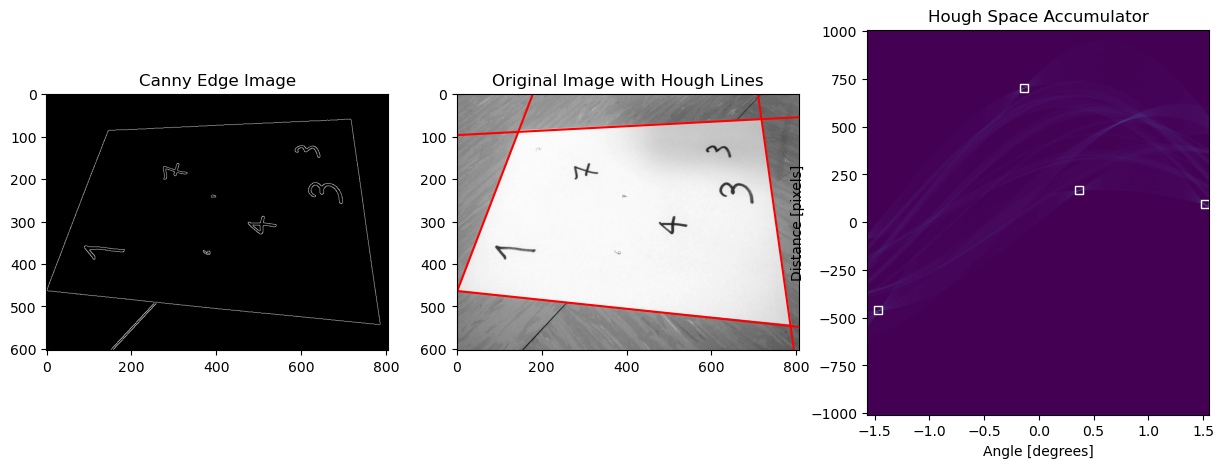

In [5]:
# plot the line on the image (same, again, expanded - repeated to have the entire code in one place)

def plot_hough_lines(image_gray, canny_sigma=1.5, canny_low_threshold=0.0, canny_high_threshold=0.3, hough_threshold=50, hough_min_distance=10, hough_num_peaks=4, hough_min_angle=10):

     # calculate hough space
     edges = canny(image_gray, sigma=canny_sigma, low_threshold=canny_low_threshold, high_threshold=canny_high_threshold, mode="nearest")
     hspace, angles, distances = hough_line(edges)
     peaks, peak_angles, peak_distances = hough_line_peaks(hspace, angles, distances, threshold=hough_threshold, min_distance=hough_min_distance, min_angle=hough_min_angle, num_peaks=hough_num_peaks)

     # plot the image and the Hough space
     fig, (ax_canny, ax_image, ax_hspace) = plt.subplots(1, 3, figsize=(15, 5))

     ax_canny.imshow(edges, cmap="gray")
     ax_canny.set_title("Canny Edge Image")

     ax_image.imshow(image_gray, cmap="gray")
     ax_image.set_title("Original Image with Hough Lines")

     H_space_image = ax_hspace.imshow(hspace, 
                                   extent=(angles[0], angles[-1], distances[0], distances[-1]), 
                                   origin="lower", 
                                   aspect="auto")
     ax_hspace.plot(peak_angles, peak_distances, 'ws', fillstyle="none")
     ax_hspace.set(xlabel="Angle [degrees]", ylabel="Distance [pixels]", title="Hough Space Accumulator")

     # plot lines on image
     for r, theta in zip(peak_distances, peak_angles):
          # Calculate two points on the line
          x0 = 0
          y0 = (r - x0 * np.cos(theta)) / np.sin(theta)
          x1 = image_gray.shape[1]  # Width of the image
          y1 = (r - x1 * np.cos(theta)) / np.sin(theta)
     
          # Plot the line on the image
          ax_image.plot((x0, x1), (y0, y1), 'r', scalex=False, scaley=False)

     
     plt.show()

plot_hough_lines(image_gray)

##### check for all training images

In [6]:
canny_sigma = 1.5
canny_low_threshold = 0.0
canny_high_threshold = 0.3

hough_threshold = 50
hough_min_distance = 10
hough_num_peaks = 4
hough_min_angle = 10
# --> best for most, set as default in function


# CHECK FOR ALL IMAGES - commented out for sake of readability of html file

# for image_name in image_files:
#     print(image_name)
#     image_gray = get_image(folder, image)
#     plot_hough_lines(image_gray, canny_sigma, canny_low_threshold, canny_high_threshold, hough_threshold, hough_min_distance, hough_num_peaks, hough_min_angle)

/var/folders/26/fnlzfq0s7lqcqtlwb5nj7_lc0000gn/T/ipykernel_6026/2502662507.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  y0 = (r - x0 * np.cos(theta)) / np.sin(theta)
/var/folders/26/fnlzfq0s7lqcqtlwb5nj7_lc0000gn/T/ipykernel_6026/2502662507.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  y1 = (r - x1 * np.cos(theta)) / np.sin(theta)


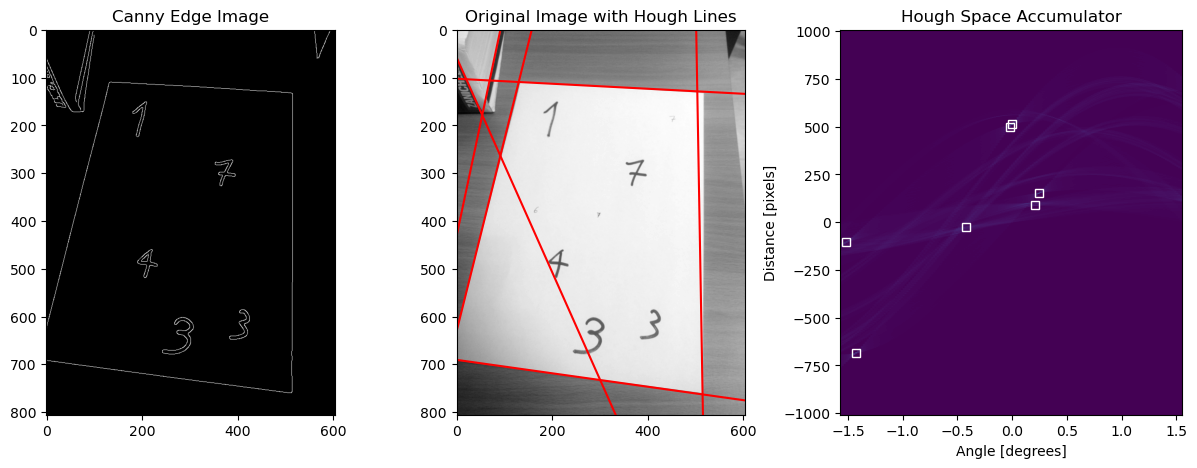

In [7]:
# investigation into problem case in order to improve generalization
image_name = "IMG_20190312_184032.jpg"   # there are other lines that are detected before the right edge is.. the right edge gets grasped 7th only. I have to find a way to set a min. length.

canny_sigma = 2.0
canny_low_threshold = 0.0
canny_high_threshold = 0.3

hough_threshold = 50
hough_min_distance = 10
hough_num_peaks = 7
hough_min_angle = 10

image_gray = get_image(folder, image)
plot_hough_lines(image_gray, canny_sigma, canny_low_threshold, canny_high_threshold, hough_threshold, hough_min_distance, hough_num_peaks, hough_min_angle)

#### interim conclusion:
- for 18 / 21 images the edges could be detected correctly with these parameters (I have tried several settings and have adjusted the default values in the function accordingly).

- To improve the rate, it would be necessary to set a min. length of a gap-free-line, which I could not figure out how to do in a reasonable amount of time for the hough_line and peak_hough_line (only probabilistic).

- I will continue with the 18 images that were classified correctly (ignoring the issues with the 3 residuals) to focus on the corner detection in order to focus my learning on the next topics. I might come back to this later if there is time left.

## 2. Find corners

Once you have the four corners of the sheet, you can obtain a straightened version of your sheet of paper, by a geometric transformation.

In [8]:
# INCORRECT - same issue as earlier, lines do not match edges this way, conversion to carthesian seems incorrect - left in here for documentation purposes

# def get_hough_lines(image_gray, canny_sigma=2.5, canny_low_threshold=0.0, canny_high_threshold=0.3, hough_threshold=50, hough_min_distance=10, hough_num_peaks=4, hough_min_angle=10):
#     # Calculate Hough space
#     edges = canny(image_gray, sigma=canny_sigma, low_threshold=canny_low_threshold, high_threshold=canny_high_threshold, mode="nearest")
#     hspace, angles, distances = hough_line(edges)
#     peaks, peak_angles, peak_distances = hough_line_peaks(hspace, angles, distances, threshold=hough_threshold, min_distance=hough_min_distance, min_angle=hough_min_angle, num_peaks=hough_num_peaks)

#     cartesian_lines = []

#     for r, theta in zip(peak_distances, peak_angles):
#         # Calculate the slope (m) and intercept (b) of the line in Cartesian coordinates
#         m =  -1 / np.tan(theta)  # Slope in Cartesian coordinates
#         b =  r / np.sin(theta)   # Intercept in Cartesian coordinates

#         # Append the Cartesian line (m, b) to the list
#         cartesian_lines.append((m, b))

#     return cartesian_lines


# def get_intersections(lines):
#     intersections = []
#     for i in range(len(lines)):
#         for j in range(i+1, len(lines)):
#             m1, b1 = lines[i]
#             m2, b2 = lines[j]
#             x = (b2 - b1) / (m1 - m2)
#             y = m1 * x + b1
#             intersections.append((x, y))
#     return intersections

In [9]:
def get_intersections(peaks, peak_angles, peak_distances):

    intersections = []
    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            theta1 = peak_angles[i]
            r1 = peak_distances[i]
            theta2 = peak_angles[j]
            r2 = peak_distances[j]

            # Calculate the intersection point from lines in hesse normal form
            D = np.cos(theta1) * np.sin(theta2) - np.cos(theta2) * np.sin(theta1)
            x = (r1 * np.sin(theta2) - r2 * np.sin(theta1)) / D
            y = (r2 * np.cos(theta1) - r1 * np.cos(theta2)) / D

            intersections.append((x, y))

    return intersections

In [10]:
def plot_hough_lines_with_intersections(image_gray, scale_factor=1.5, canny_sigma=1.5, canny_low_threshold=0.0, canny_high_threshold=0.3, hough_threshold=50, hough_min_distance=10, hough_num_peaks=4, hough_min_angle=10):

    # calculate hough space
    edges = skimage.feature.canny(image_gray, sigma=canny_sigma, low_threshold=canny_low_threshold, high_threshold=canny_high_threshold, mode="nearest")
    hspace, angles, distances = hough_line(edges)
    peaks, peak_angles, peak_distances = hough_line_peaks(hspace, angles, distances, threshold=hough_threshold, min_distance=hough_min_distance, min_angle=hough_min_angle, num_peaks=hough_num_peaks)

    intersections = get_intersections(peaks, peak_angles, peak_distances)

    # Plot the image and the Hough space
    fig, (ax_image) = plt.subplots(1, 1, figsize=(8, 8))

    ax_image.imshow(image_gray, cmap="gray")
    ax_image.set_title("Original Image with Hough lines and intersections")

    # scale axes to show intersections outside image space
    scale_factor = scale_factor
    x_lim, y_lim = ax_image.get_xlim(), ax_image.get_ylim()
    x_center, y_center = (x_lim[0] + x_lim[1]) / 2, (y_lim[0] + y_lim[1]) / 2
    x_scale, y_scale = (x_lim[1] - x_lim[0]) * scale_factor, (y_lim[1] - y_lim[0]) * scale_factor
    ax_image.set_xlim(x_center - x_scale / 2, x_center + x_scale / 2)
    ax_image.set_ylim(y_center - y_scale / 2, y_center + y_scale / 2)

    # Plot lines on the image
    for r, theta in zip(peak_distances, peak_angles):
        # Calculate two points on the line
        x0 = 0
        y0 = (r - x0 * np.cos(theta)) / np.sin(theta)
        x1 = image_gray.shape[1]  # Width of the image
        y1 = (r - x1 * np.cos(theta)) / np.sin(theta)
        
        # Plot the line on the image
        ax_image.plot((x0, x1), (y0, y1), 'r', scalex=False, scaley=False)

    # plot & annotate intersection points
    for i, (x, y) in enumerate(intersections):
        ax_image.plot(x, y, 'yo', markersize=15, markerfacecolor='yellow')
        ax_image.annotate(str(i+1), (x, y), fontsize=14, color='black', fontweight='bold')

    plt.show()
    return intersections

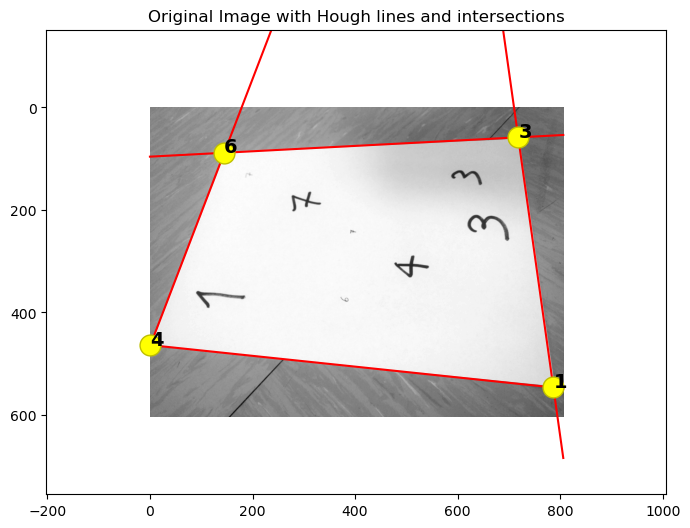

[(786.6753107488867, 546.2222238174312),
 (567.593061067678, -1012.628982276058),
 (718.1298816335865, 58.496152882590984),
 (0.9084877557208855, 463.6348027895944),
 (-2332.5685517744655, 218.37648303975948),
 (144.8946059993987, 88.53814068528074)]

In [11]:
image_name="IMG_20190312_183838.jpg"
image_gray = get_image(folder, image_name)
plot_hough_lines_with_intersections(image_gray)

**open question:** how to detect which intersections belong to the edges of the paper?

**solution ideas:** 
- Plan A: find connected components, draw bounding box, increase it slightly to make sure intersections are inside box, check if intersection is in box
- Plan B: check distance to image center

## 3. Detect paper to know, which corners belong to it  
(overkill method, could have just measured distance from center, but done now anyways)

In [12]:
image_name = "IMG_20190312_183838.jpg"
image_gray = get_image(folder, image)

@widgets.interact(threshold=(0, 1, 0.05))
def f(threshold):
    mask = image_gray > threshold
    plt.imshow(mask)

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

for this image, 0.65 is a good threshold

#### check for all images

In [13]:
#  CHECK FOR ALL IMAGES - commented out for sake of readability of html file

threshold = 0.63 # best for most images, figured out by iterative trial and error
# for image_name in image_files:
#     print(image_name)
#     image_gray = get_image(folder, image_name)
#     mask = image_gray > threshold
#     plt.imshow(mask)
#     plt.show()

### connected component analysis
Separating and analyzing the "islands" of `True` pixels in a binary image is called _connected component analysis_ ([documentation](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)).

In [14]:
image_name = "IMG_20190312_183838.jpg"
image_gray = get_image(folder, image_name)
mask = image_gray > threshold
labels = label(mask)
print(np.unique(labels))

[0 1 2 3 4 5 6]


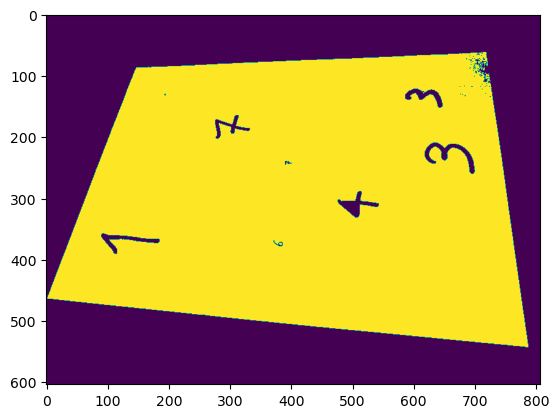

In [15]:
label = 1 # 0=background, 1=sheet, rest are small dots etc.
plt.imshow(labels==label)

The `regionprops` ([documentation](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)) function can compute properties for each connected component.  Some important properties are the following:

- `area : int` Number of pixels of the region.
- `bbox : tuple` Bounding box `(min_row, min_col, max_row, max_col)`. Pixels belonging to the bounding box are in the half-open interval `[min_row; max_row)` and `[min_col; max_col)`.
- `centroid : array` Centroid coordinate tuple `(row, col)`.
- `convex_area : int` Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.
- `label : int` The label in the labeled input image.

Let's select only the large regions

In [16]:
regions = regionprops(labels)
large_regions = [r for r in regions if r.area > 10000]
print(len(large_regions)) # visual inspection confirmed, assuming backdrop is ignored

1


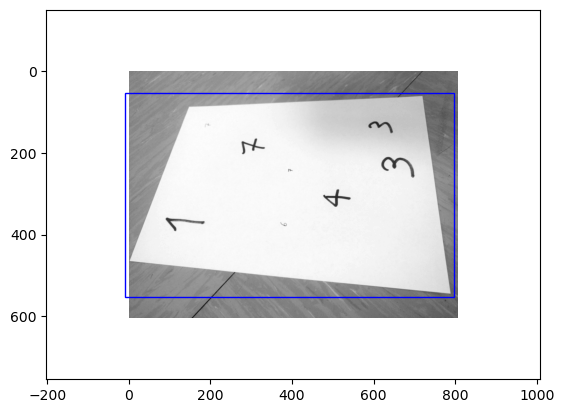

In [30]:
def plot_bounding_box(image, padding=10, threshold=0.63):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap="gray")

    mask = image_gray > threshold
    labels = skimage.measure.label(mask)  # somehow importing label from skimage.measure does not work
    regions = regionprops(labels)
    largest_box = max(regions, key=lambda r: (r.bbox[2] - r.bbox[0]) * (r.bbox[3] - r.bbox[1]))

    (min_row, min_col, max_row, max_col) = largest_box.bbox
    width = max_col - min_col
    height = max_row - min_row

    # Add some inner padding, so that the corners are inside the box
    min_row -= padding
    min_col -= padding
    width += 2 * padding
    height += 2 * padding

    rect = patches.Rectangle((min_col, min_row), width, height,
                            linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

    scale_factor = 1.5
    x_lim, y_lim = ax_image.get_xlim(), ax_image.get_ylim()
    x_center, y_center = (x_lim[0] + x_lim[1]) / 2, (y_lim[0] + y_lim[1]) / 2
    x_scale, y_scale = (x_lim[1] - x_lim[0]) * scale_factor, (y_lim[1] - y_lim[0]) * scale_factor
    ax.set_xlim(x_center - x_scale / 2, x_center + x_scale / 2)
    ax.set_ylim(y_center - y_scale / 2, y_center + y_scale / 2)
    
    plt.show()

plot_bounding_box(image_gray, padding=10, threshold=0.63)

In [33]:
def filter_intersections_with_box(image_gray, axis_scale_factor=2, padding=200, threshold=0.63, plot=True):
    mask = image_gray > threshold
    labels = skimage.measure.label(mask) # somehow importing label from skimage.measure does not work
    regions = regionprops(labels)
    largest_box = max(regions, key=lambda r: (r.bbox[2] - r.bbox[0]) * (r.bbox[3] - r.bbox[1]))

    (min_row, min_col, max_row, max_col) = largest_box.bbox
    width = max_col - min_col
    height = max_row - min_row

    # Add some inner padding, so that the corners are inside the box
    min_row -= padding
    min_col -= padding
    max_row += padding
    max_col += padding
    width += 2 * padding
    height += 2 * padding

    # calculate hough space
    edges = skimage.feature.canny(image_gray, sigma=canny_sigma, low_threshold=canny_low_threshold, high_threshold=canny_high_threshold, mode="nearest")
    hspace, angles, distances = hough_line(edges)
    peaks, peak_angles, peak_distances = hough_line_peaks(hspace, angles, distances, threshold=hough_threshold, min_distance=hough_min_distance, min_angle=hough_min_angle, num_peaks=hough_num_peaks)
    intersections = get_intersections(peaks, peak_angles, peak_distances)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image_gray, cmap="gray")
    rect = patches.Rectangle((min_col, min_row), width, height,
                            linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

    relevant_intersections = []

    if intersections is not None:
            for x, y in intersections:
                if min_col < x < max_col and min_row < y < max_row:
                    # Check if the intersection is within the bounding box
                    relevant_intersections.append((x, y))
                    ax.plot(x, y, 'go', markersize=10, markerfacecolor='green', scalex=False, scaley=False)
                else:
                    # Intersection lies outside the bounding box
                    ax.plot(x, y, 'ro', markersize=10, markerfacecolor='red', scalex=False, scaley=False)

    scale_factor = axis_scale_factor
    x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
    x_center, y_center = (x_lim[0] + x_lim[1]) / 2, (y_lim[0] + y_lim[1]) / 2
    x_scale, y_scale = (x_lim[1] - x_lim[0]) * scale_factor, (y_lim[1] - y_lim[0]) * scale_factor
    ax.set_xlim(x_center - x_scale / 2, x_center + x_scale / 2)
    ax.set_ylim(y_center - y_scale / 2, y_center + y_scale / 2)

    if plot:
        plt.show()
    else:
        plt.close(fig)

    return relevant_intersections

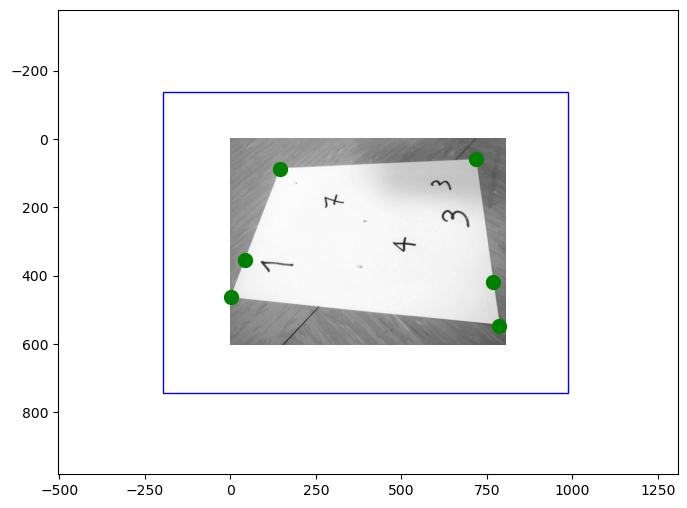

[(786.6753107488867, 546.2222238174312),
 (718.1298816335865, 58.496152882590984),
 (768.7381675253106, 418.5928180183288),
 (0.9084877557208855, 463.6348027895944),
 (144.8946059993987, 88.53814068528074),
 (42.5854191563388, 355.0626845478509)]

In [34]:
filter_intersections_with_box(image_gray, axis_scale_factor=2.25, padding=200, threshold=0.63)

In [35]:
# CHECK FOR ALL IMAGES - commented out for sake of readability of html file

# for image_name in image_files:
#     print(image_name)
#     image_gray = get_image(folder, image_name)
#     filter_intersections_with_box(image_gray, axis_scale_factor=2, padding=250, threshold=0.63)

## 3. Straighten the image

In [36]:
# definition of corners of an A4 paper to map the edges to - coordinate system origin = top left corner of the paper
# reminder: this is now defined with the portrait image in mind. to match the corners of the landscape image, a rotation of the edges will be needed

w, h = 210*2, 297*2 # assuming 2 pixel per mm to be in +/- same size range as the resized image

TOP_LEFT = np.array([0,0])
TOP_RIGHT = np.array([w,0])
BOTTOM_LEFT = np.array([0,h])
BOTTOM_RIGHT = np.array([w,h])

edges_to_map_to = (TOP_LEFT, TOP_RIGHT, BOTTOM_LEFT, BOTTOM_RIGHT)


**Idea to generalize:**
- set point as d0 where x and y are minimal
- set point as a0 where x is minimal
- set point as b0 where x and y are maximal
- set last point as c0

**correct orientation:**
- when average of distance(a,d) and distance (b,c) is shorter than the average of distance(d,c) and the distance(a,b): the paper is portrait oriented and the corners need to rotated to map correctly to the defined corners
    - then:  a0 -> b,  d0 -> a,  c0 -> d,  b0 -> c
    - else:  rotate somehow


In [37]:
# EXAMPLE IMAGES
#image_name="IMG_20190312_183838.jpg" # landscape
image_name="IMG_20190312_183849.jpg" # portrait
image_gray = get_image(folder, image_name)

intersections_filtered = filter_intersections_with_box(image_gray, axis_scale_factor=2, padding=200, threshold=0.63, plot=False)
intersections_filtered

[(501.9315874950677, 596.88076341656),
 (142.85148936857829, 584.3414100808108),
 (466.5982116163651, 193.01842908986345),
 (193.2468859014337, 173.90384234208616)]

In [38]:
# generalization 

def assign_edges(intersections_filtered):
    # assign provisional points according to a heuristic as described in comments (developed through trial and error, a lot of it...)
    list_intersections = intersections_filtered.copy() # copy of the intersections of which the points are subsequently removed
    print(list_intersections)
    
    tl_0 =   min(list_intersections, key=lambda point: np.linalg.norm(np.array(point))) # select the point where the distance to the origin is minimal
    list_intersections.remove(tl_0)

    br_0 =  max(list_intersections, key=lambda point: np.linalg.norm(np.array(point))) # select the point where the distance to the origin is maximal
    list_intersections.remove(br_0)

    bl_0 =   min(list_intersections, key=lambda point: point[0]) # select the point from the remaining entries where x is minimal and remove from list
    list_intersections.remove(bl_0)
    
    tr_0 =   list_intersections[0] # select the remaining point from the list
    
    return tl_0, tr_0, bl_0, br_0

def check_landscape_or_portrait(tl_0, tr_0, bl_0, br_0):
        # Convert the points to NumPy arrays for distance calculations
    br_0 = np.array(br_0)
    tl_0 = np.array(tl_0)
    tr_0 = np.array(tr_0)
    bl_0 = np.array(bl_0)

    # Calculate distances to determine whether the sheet is displayed in landscape or portrait mode
    distance_br_tr = np.linalg.norm(br_0 - tr_0)
    distance_bl_tl = np.linalg.norm(bl_0 - tl_0)
    avg_distance_bottom_top = (distance_br_tr + distance_bl_tl) // 2

    distance_tr_tl = np.linalg.norm(tr_0 - tl_0)
    distance_br_bl = np.linalg.norm(br_0 - bl_0)
    avg_distance_left_right = (distance_tr_tl + distance_br_bl) // 2

    if avg_distance_bottom_top > avg_distance_left_right: # if portrait, assign the provisional points definitely, as the corners of the should-be A4 paper were defined with portrait image in mind
        top_left = tl_0
        top_right = tr_0
        bottom_left = bl_0
        bottom_right = br_0
        
    else: # else (if landscape) rotate the points once counter-clockwise - figured out by trying it on a landscape image and reassigning the points
        top_right = tl_0
        bottom_right = tr_0
        top_left = bl_0
        bottom_left = br_0
    
    return top_left, top_right, bottom_left, bottom_right


def get_edges_for_mapping(image_gray):
    intersections_filtered = filter_intersections_with_box(image_gray, padding=200, threshold=0.63, plot=False)
    if len(intersections_filtered) == 4:

        tl_0, tr_0, bl_0, br_0 = assign_edges(intersections_filtered)

        top_left, top_right, bottom_left, bottom_right = check_landscape_or_portrait(tl_0, tr_0, bl_0, br_0)

        edges_detected_and_sorted = (top_left, top_right, bottom_left, bottom_right)

        return edges_detected_and_sorted
    else:
        print("Error: Number of intersections is not 4")
        return None

In [39]:
def plot_assigned_edges(image_gray):

    edges_detected_and_sorted = get_edges_for_mapping(image_gray)

    if edges_detected_and_sorted is not None:

        top_left, top_right, bottom_left, bottom_right = edges_detected_and_sorted

        plt.imshow(image_gray, cmap="gray")

        plt.plot(top_left[0], top_left[1], 'ob')
        plt.text(top_left[0], top_left[1], f'top left\n({top_left[0]:.2f}, {top_left[1]:.2f})', color="b")

        plt.plot(top_right[0], top_right[1], 'ob')
        plt.text(top_right[0], top_right[1], f'top right\n({top_right[0]:.2f}, {top_right[1]:.2f})', color="b")

        plt.plot(bottom_left[0], bottom_left[1], 'ob')
        plt.text(bottom_left[0], bottom_left[1], f'bottom left\n({bottom_left[0]:.2f}, {bottom_left[1]:.2f})', color="b")

        plt.plot(bottom_right[0], bottom_right[1], 'ob')
        plt.text(bottom_right[0], bottom_right[1], f'bottom right\n({bottom_right[0]:.2f}, {bottom_right[1]:.2f})', color="b")

        plt.show()


[(501.9315874950677, 596.88076341656), (142.85148936857829, 584.3414100808108), (466.5982116163651, 193.01842908986345), (193.2468859014337, 173.90384234208616)]


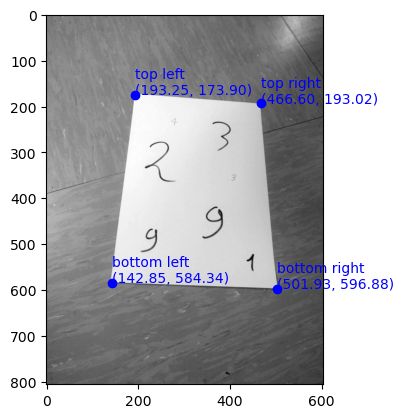

In [40]:
image_name="IMG_20190312_183849.jpg" # portrait - success!
image_gray = get_image(folder, image_name)
plot_assigned_edges(image_gray)

In [41]:
image_name="IMG_20190312_183838.jpg" # landscape - success!
image_gray = get_image(folder, image_name)
plot_assigned_edges(image_gray)

Error: Number of intersections is not 4


In [42]:
# CHECK FOR ALL IMAGES - commented out for sake of readability of html file

# for image in image_files:
#     print(image)
#     image_gray = get_image(image)
#     try:
#         plot_assigned_edges(image_gray)
#     except Exception as e:
#         print(f"Error processing {image}: {e}")
#         continue

**intermediary conclusion:** quite ok for most images, remaining problem: the heuristic cannot detect if an image is upside down and I cannot come up with a feedback method other than my eyes.. some indicator that is detectable would be needed. I fear it is not possible to know prior to further interpretation of what is on the paper.  - I will live with it for now and continue with the excercise. I might come back if I have an idea or adress it at a later stage.

In [43]:
def plot_straightened_image(image_gray, edges_to_map_to):
    
    TOP_LEFT, TOP_RIGHT, BOTTOM_LEFT, BOTTOM_RIGHT = edges_to_map_to

    edges_detected_and_sorted = get_edges_for_mapping(image_gray)
    if edges_detected_and_sorted is  None:
        print("Image cannot be straightened")

    else:
        top_left, top_right, bottom_left, bottom_right = edges_detected_and_sorted

        # creating an object mapping the coordinates in the image to the target coordinates
        invtf = estimate_transform("projective",
            src=np.vstack((TOP_LEFT, TOP_RIGHT, BOTTOM_LEFT, BOTTOM_RIGHT)),
            dst=np.vstack((top_left, top_right, bottom_left, bottom_right)))
        
        fig,(ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
        
        # plot grid
        ax1.imshow(image_gray, cmap="gray")
        for x in np.arange(0,w,25):
            for y in np.arange(0,h,20):
                p = invtf((x,y))
                ax1.plot(p[0,0],p[0,1],'g.')

        # plot edges
        ax1.plot(top_left[0], top_left[1], 'ob')
        ax1.text(top_left[0], top_left[1], f'top left\n({top_left[0]:.2f}, {top_left[1]:.2f})', color="b")
        ax1.plot(top_right[0], top_right[1], 'ob')
        ax1.text(top_right[0], top_right[1], f'top right\n({top_right[0]:.2f}, {top_right[1]:.2f})', color="b")
        ax1.plot(bottom_left[0], bottom_left[1], 'ob')
        ax1.text(bottom_left[0], bottom_left[1], f'bottom left\n({bottom_left[0]:.2f}, {bottom_left[1]:.2f})', color="b")
        ax1.plot(bottom_right[0], bottom_right[1], 'ob')
        ax1.text(bottom_right[0], bottom_right[1], f'bottom right\n({bottom_right[0]:.2f}, {bottom_right[1]:.2f})', color="b")

        # plot straightened image
        tim = warp(image=image_gray, 
            inverse_map=invtf, 
            output_shape=(h,w) # columns,rows
        )
        ax2.imshow(tim)        
        plt.show()
        

IMG_20190312_185258.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_184032.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183952.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_185307.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183945.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183956.jpg
[(273.0861230877424, 68.83179498885546), (-74.7478393685919, 455.1405467754879), (633.2347690770623, 30.978646970179092), (375.9026374394725, 637.215158091064)]


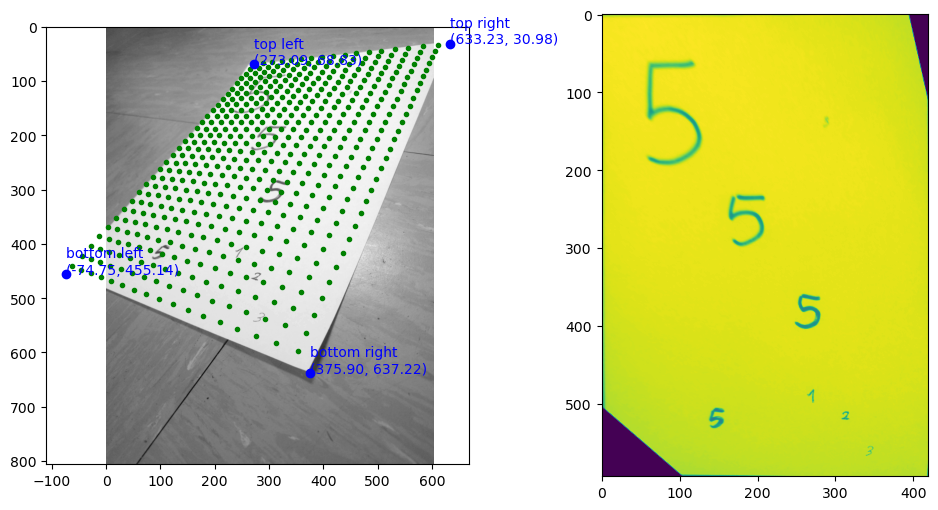

IMG_20190312_184045.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_184053.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183852.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183932.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183841.jpg
[(439.5936357541365, 581.7985099641744), (483.4880784326378, 164.17078480593142), (57.29266593407624, 493.53737659626864), (199.70517717707256, 55.23673525591314)]


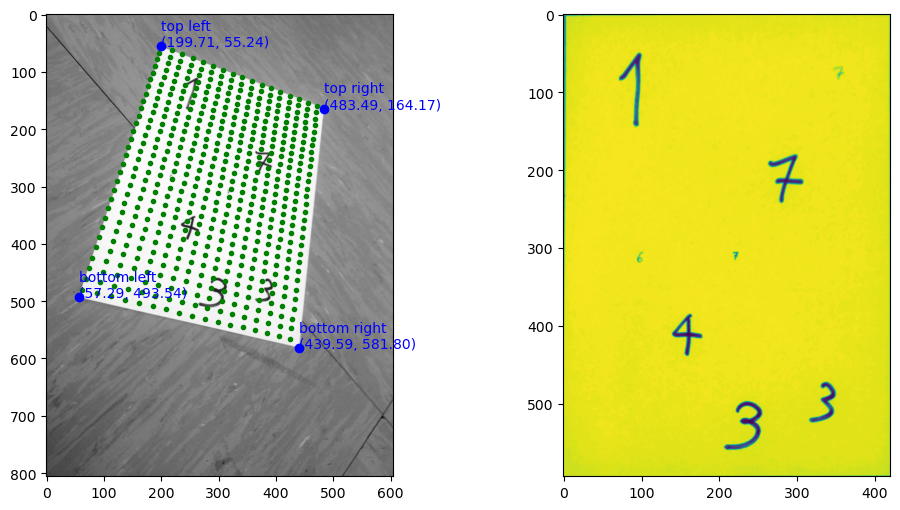

IMG_20190312_183855.jpg
[(507.0, 507.75354331611874), (257.38274030730224, 463.73928558178454), (507.0, 221.2257513416832), (308.8554966977579, 171.82277805898119)]


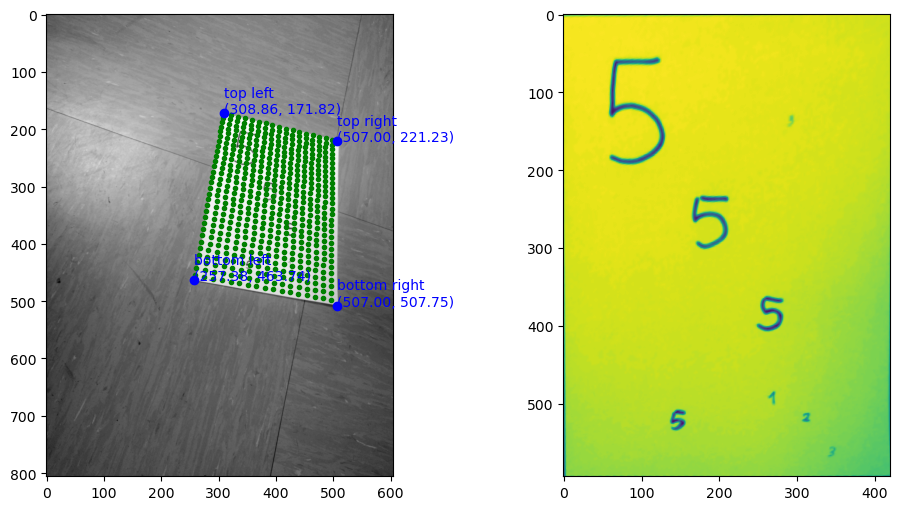

IMG_20190312_185226.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183858.jpg
[(33.755200466392196, 456.04801934391077), (284.3033713012818, 157.45633663352325), (483.62459433934515, 619.787088021044), (560.1250419731532, 226.22640292301045)]


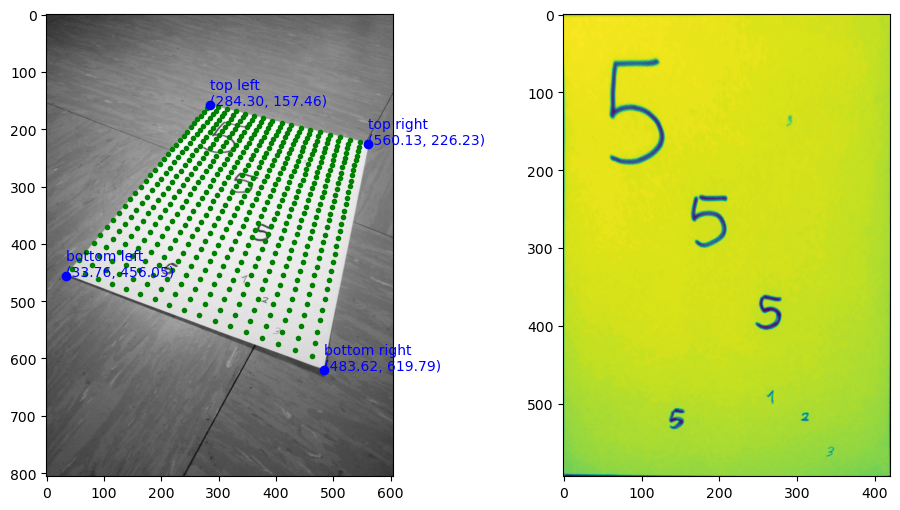

IMG_20190312_183910.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183913.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183902.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_183849.jpg
[(501.9315874950677, 596.88076341656), (142.85148936857829, 584.3414100808108), (466.5982116163651, 193.01842908986345), (193.2468859014337, 173.90384234208616)]


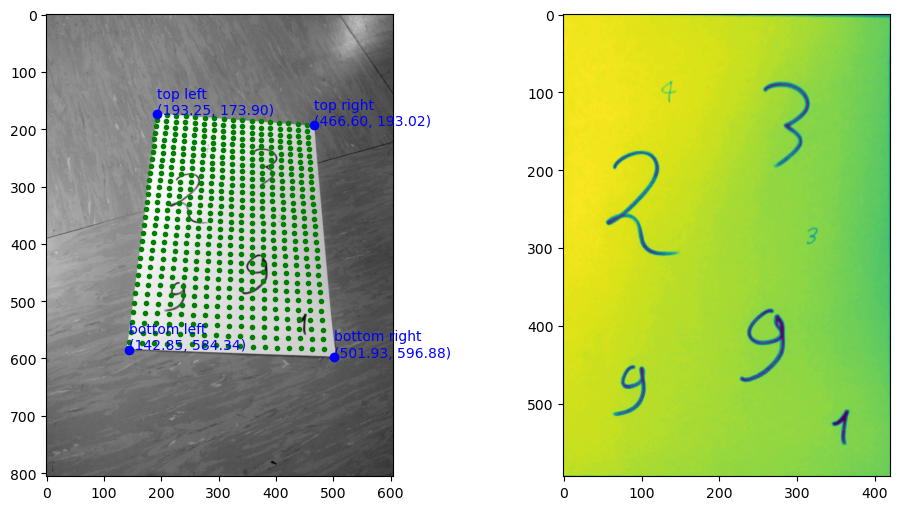

IMG_20190312_185251.jpg
[(576.2504078378275, 255.00000000000003), (8.550938707875309, 255.0), (590.176859697313, 653.8014027805524), (1.2308456436963116, 674.3678507804024)]


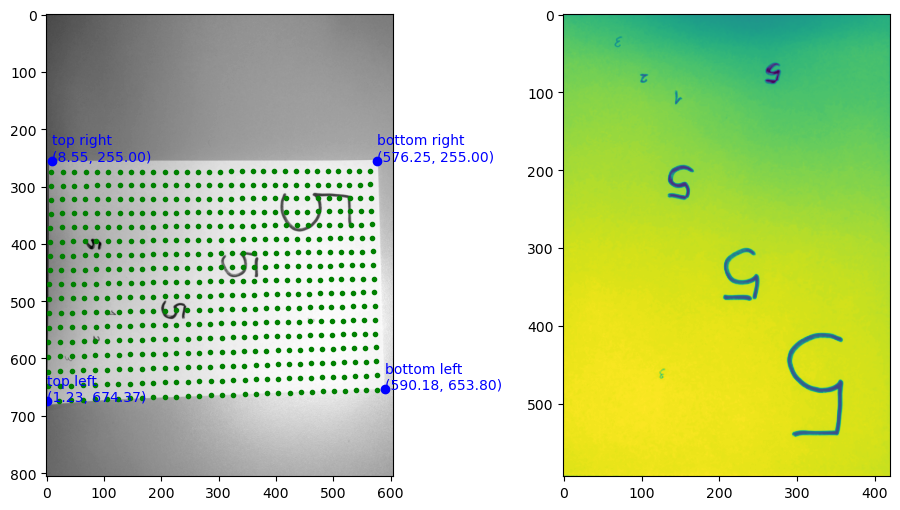

IMG_20190312_183838.jpg
Error: Number of intersections is not 4
Image cannot be straightened
IMG_20190312_185240.jpg
Error: Number of intersections is not 4
Image cannot be straightened


In [44]:
for image in image_files:
    print(image)
    image_gray = get_image(image)
    try:
        plot_straightened_image(image_gray, edges_to_map_to)
    except Exception as e:
        print(f"Error processing {image}: {e}")
        continue


there is an ominous thing going on.. I tried to programm the function so that it does not create the plot when it cannot detect the four edges (not grasp the lines etc.) but it stubbornly still plots all of them completely against my understanding how this is possible and some of it surprisingly good even though I get the error messages which is hilarious and confusing hahaha


weirdly it does now, on the second run of the entire workbook, but it seems I have lost some images in the process and reduced the sucess rate drastically.. I will have to go through and see why this is if there is time left

In [51]:
def save_straightened_image_only(image_gray, image_name, edges_to_map_to):
    
    TOP_LEFT, TOP_RIGHT, BOTTOM_LEFT, BOTTOM_RIGHT = edges_to_map_to

    edges_detected_and_sorted = get_edges_for_mapping(image_gray)
    if edges_detected_and_sorted is  None:
        print("Image cannot be straightened")

    else:
        top_left, top_right, bottom_left, bottom_right = edges_detected_and_sorted

        # creating an object mapping the coordinates in the image to the target coordinates
        invtf = estimate_transform("projective",
            src=np.vstack((TOP_LEFT, TOP_RIGHT, BOTTOM_LEFT, BOTTOM_RIGHT)),
            dst=np.vstack((top_left, top_right, bottom_left, bottom_right)))
        
        fig,ax = plt.subplots(figsize=(12,12))
        
        # plot straightened image
        tim = warp(image=image_gray, 
            inverse_map=invtf, 
            output_shape=(h,w) # columns,rows
        )
        ax.imshow(tim)        
        ax.set_axis_off()  # Turn off the axes

        output_folder = "straightened_images"
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        output_path = os.path.join(output_folder, "straightened_"+image_name)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()


In [62]:
# SAVE IMAGES

# for image in image_files:
#     print(image)
#     image_gray = get_image(image)
#     try:
#         save_straightened_image_only(image_gray, image, edges_to_map_to)
#     except Exception as e:
#         print(f"Error processing {image}: {e}")
#         continue

## 4. Detect numbers on the paper

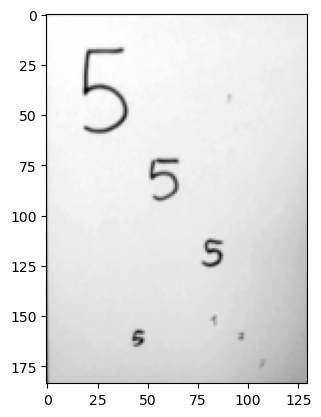

In [61]:
# example images to go ahead with the learning

#image_name = "straightened_IMG_20190312_183841.jpg"
#image_name = "straightened_IMG_20190312_183849.jpg"
image_name = "straightened_IMG_20190312_183855.jpg"

image_gray = get_image(folder, image_name)
plt.imshow(image_gray, cmap="gray")


In [49]:
# Cut a square bounding box around each connected component.  tip by Luzian: use average color of background for bounding box

In [50]:
# Resize that to a 28 x 28 and classify it using a convnet trained on the MNIST dataset.